In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
from flipper_training.experiments.ppo.eval import get_eval_rollout, log_from_eval_rollout, PPOExperimentConfig
import contextlib
from tqdm import tqdm
import pickle
import os
import sys
import torch

In [2]:
with open("../cross_eval_configs/cross_eval_seeds.txt") as f:
    seeds = list(map(int, f.readlines()))

print(seeds)

[12345, 67890, 11121, 31415, 92653, 58979, 32384, 62643, 38327, 95028, 84626, 43383, 27950, 28841, 97169, 39937, 51058, 20974, 94459, 23078, 16406, 28620, 89986, 28034, 82534, 21170, 68214, 90559, 27174, 67283]


In [3]:
run = "final_trunk_thesis_training_42_2025-05-09_21-01-13"

In [4]:
run_path = Path("../runs/ppo") / run
weights_step = "final"
train_config = OmegaConf.load(run_path / "config.yaml")
train_config.policy_weights_path = run_path / "weights" / f"policy_{weights_step}.pth"
train_config.vecnorm_weights_path = run_path / "weights" / f"vecnorm_{weights_step}.pth"

assert train_config.policy_weights_path.exists(), f"Policy weights not found at {train_config.policy_weights_path}"
assert train_config.vecnorm_weights_path.exists(), f"Vecnorm weights not found at {train_config.vecnorm_weights_path}"

In [5]:
train_config["num_robots"] = 16
train_config["objective_opts"]["cache_size"] = 10
train_config["max_eval_steps"] = 1000
train_config = PPOExperimentConfig(**train_config)

In [6]:
test_configs_base = Path("../cross_eval_configs")
eval_results_base = Path("../cross_eval_results") / run
eval_results_base.mkdir(parents=True, exist_ok=True)

In [7]:
devnull_handle = open(os.devnull, "w")

In [ ]:
# Training environment
if not (eval_results_base / "training.pkl").exists():
    print("Evaluating training environment")
    results = []
    for seed in tqdm(seeds, desc="Training environment"):
        tqdm.write(f"Evaluating seed {seed}")
        train_config.seed = seed
        with contextlib.redirect_stdout(devnull_handle):
            with contextlib.redirect_stderr(devnull_handle):
                _, eval_rollout = get_eval_rollout(train_config)
        log = log_from_eval_rollout(eval_rollout)
        results.append(log)
    with open(eval_results_base / "training.pkl", "wb") as f:
        pickle.dump(results, f)

for test_config_path in test_configs_base.glob("*.yaml"):
    if (eval_results_base / test_config_path.stem).exists():
        print(f"Skipping {test_config_path.stem} as it already exists")
        continue
    print(f"Evaluating {test_config_path.stem}")
    test_config = OmegaConf.load(test_config_path)
    train_config.objective_opts = test_config["objective_opts"]
    train_config.heightmap_gen_opts = test_config["heightmap_gen_opts"]
    train_config.objective = test_config["objective"]
    train_config.heightmap_gen = test_config["heightmap_gen"]
    results = []
    for seed in tqdm(seeds, desc=f"Evaluating {test_config_path.stem}"):
        train_config.seed = seed
        with contextlib.redirect_stdout(devnull_handle):
            with contextlib.redirect_stderr(devnull_handle):
                _, eval_rollout = get_eval_rollout(train_config)
        log = log_from_eval_rollout(eval_rollout)
        results.append(log)

    with open(eval_results_base / f"{test_config_path.stem}.pkl", "wb") as f:
        pickle.dump(results, f)

Evaluating training environment


Training environment:   0%|          | 0/30 [00:00<?, ?it/s]

Evaluating seed 12345


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:27:28,085 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:   3%|▎         | 1/30 [00:18<08:57, 18.53s/it]

Evaluating seed 67890


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:27:41,102 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:   7%|▋         | 2/30 [00:32<07:18, 15.65s/it]

Evaluating seed 11121


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:27:54,839 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  10%|█         | 3/30 [00:45<06:39, 14.80s/it]

Evaluating seed 31415


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:28:08,801 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  13%|█▎        | 4/30 [01:00<06:19, 14.60s/it]

Evaluating seed 92653


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:28:23,005 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  17%|█▋        | 5/30 [01:14<05:57, 14.30s/it]

Evaluating seed 58979


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:28:36,882 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  20%|██        | 6/30 [01:27<05:37, 14.05s/it]

Evaluating seed 32384


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:28:50,496 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  23%|██▎       | 7/30 [01:42<05:26, 14.21s/it]

Evaluating seed 62643


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:29:05,117 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  27%|██▋       | 8/30 [01:56<05:13, 14.25s/it]

Evaluating seed 38327


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:29:19,508 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  30%|███       | 9/30 [02:10<04:56, 14.12s/it]

Evaluating seed 95028


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:29:33,325 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  33%|███▎      | 10/30 [02:25<04:46, 14.34s/it]

Evaluating seed 84626


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:29:48,175 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  37%|███▋      | 11/30 [02:39<04:31, 14.31s/it]

Evaluating seed 43383


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:30:02,343 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  40%|████      | 12/30 [02:53<04:14, 14.17s/it]

Evaluating seed 27950


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:30:16,363 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  43%|████▎     | 13/30 [03:07<04:02, 14.25s/it]

Evaluating seed 28841


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:30:30,819 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  47%|████▋     | 14/30 [03:22<03:48, 14.31s/it]

Evaluating seed 97169


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:30:45,281 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  50%|█████     | 15/30 [03:36<03:34, 14.31s/it]

Evaluating seed 39937


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:30:59,561 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  53%|█████▎    | 16/30 [03:50<03:19, 14.23s/it]

Evaluating seed 51058


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:31:13,677 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  57%|█████▋    | 17/30 [04:05<03:07, 14.45s/it]

Evaluating seed 20974


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:31:28,759 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  60%|██████    | 18/30 [04:20<02:53, 14.49s/it]

Evaluating seed 94459


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:31:43,373 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  63%|██████▎   | 19/30 [04:34<02:39, 14.49s/it]

Evaluating seed 23078


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:31:57,766 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  67%|██████▋   | 20/30 [04:49<02:24, 14.50s/it]

Evaluating seed 16406


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:32:12,492 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  70%|███████   | 21/30 [05:03<02:11, 14.61s/it]

Evaluating seed 28620


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:32:27,381 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  73%|███████▎  | 22/30 [05:18<01:57, 14.72s/it]

Evaluating seed 89986


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:32:42,339 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  77%|███████▋  | 23/30 [05:33<01:43, 14.79s/it]

Evaluating seed 28034


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:32:57,411 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  80%|████████  | 24/30 [05:48<01:28, 14.82s/it]

Evaluating seed 82534


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:33:12,328 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  83%|████████▎ | 25/30 [06:03<01:13, 14.79s/it]

Evaluating seed 21170


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:33:27,074 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  87%|████████▋ | 26/30 [06:18<00:59, 14.84s/it]

Evaluating seed 68214


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:33:42,133 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  90%|█████████ | 27/30 [06:33<00:44, 14.78s/it]

Evaluating seed 90559


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:33:56,779 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  93%|█████████▎| 28/30 [06:47<00:29, 14.76s/it]

Evaluating seed 27174


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:34:11,643 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment:  97%|█████████▋| 29/30 [07:03<00:14, 14.91s/it]

Evaluating seed 67283


                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │               TrunkCrossing │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:34:27,038 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Training environment: 100%|██████████| 30/30 [07:18<00:00, 14.62s/it]


Evaluating gauss_fine_hard


Evaluating gauss_fine_hard:   0%|          | 0/30 [00:00<?, ?it/s]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:34:43,021 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:   3%|▎         | 1/30 [00:18<08:55, 18.45s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:35:02,103 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:   7%|▋         | 2/30 [00:38<09:02, 19.37s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:35:21,993 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  10%|█         | 3/30 [00:58<08:54, 19.81s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:35:42,435 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  13%|█▎        | 4/30 [01:20<08:51, 20.46s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:36:03,781 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  17%|█▋        | 5/30 [01:40<08:30, 20.43s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:36:23,978 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  20%|██        | 6/30 [02:00<08:03, 20.14s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:36:43,698 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  23%|██▎       | 7/30 [02:19<07:37, 19.91s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:37:03,066 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  27%|██▋       | 8/30 [02:39<07:16, 19.85s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:37:22,963 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  30%|███       | 9/30 [02:58<06:53, 19.68s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:37:42,394 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  33%|███▎      | 10/30 [03:18<06:34, 19.71s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:38:02,301 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  37%|███▋      | 11/30 [03:39<06:23, 20.16s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:38:23,240 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  40%|████      | 12/30 [03:59<06:01, 20.08s/it]

                 Environment Summary                 
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                 Key ┃                       Value ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    Number of robots │                          16 │
│        Observations │ LocalStateVector, Heightmap │
│              Reward │               PotentialGoal │
│           Objective │   RandomNavigationObjective │
│   Physics frequency │                   142.86 Hz │
│   Engine iters/step │                           4 │
│ Effective frequency │                    35.71 Hz │
└─────────────────────┴─────────────────────────────┘

2025-05-12 17:38:43,379 [torchrl][INFO] check_env_specs succeeded!


     Policy Parameter Counts     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃        Component ┃ Parameters ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│    Actor Encoder │     32,032 │
│       Actor Head │     13,456 │
│    Value Encoder │     32,032 │
│       Value Head │     12,737 │
│              --- │        --- │
│      Total Actor │     45,488 │
│      Total Value │     44,769 │
│              --- │        --- │
│ Total Parameters │     90,257 │
└──────────────────┴────────────┘

Evaluating gauss_fine_hard:  43%|████▎     | 13/30 [04:20<05:46, 20.38s/it]

In [ ]:
results_dict = {}
for f in eval_results_base.glob("*.pkl"):
    with open(f, "rb") as r:
        results = pickle.load(r)
    results_dict[f.stem] = results

In [ ]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    """
    Convert a list of dictionaries to a dictionary of lists.
    """
    dict_of_lists = {}
    for d in list_of_dicts:
        for k, v in d.items():
            if k not in dict_of_lists:
                dict_of_lists[k] = []
            dict_of_lists[k].append(v)
    return dict_of_lists

In [ ]:
results_transposed = {k: list_of_dicts_to_dict_of_lists(v) for k, v in results_dict.items()}
results_transposed.keys()

dict_keys(['gauss_coarse_hard', 'barrier_hard', 'gauss_fine_hard', 'gauss_fine_easy', 'trunk_easy', 'gauss_coarse_easy', 'barrier_easy', 'stairs_hard', 'stairs_easy'])

In [ ]:
key2name = {
    "training": "Training Dist",
    "stairs_hard": "Stairs-Hard",
    "stairs_easy": "Stairs-Easy",
    "barrier_easy": "Barrier-Easy",
    "barrier_hard": "Barrier-Hard",
    "gauss_coarse_hard": "Gauss-Coarse-Hard",
    "gauss_fine_easy": "Gauss-Fine-Easy",
    "gauss_fine_hard": "Gauss-Fine-Hard",
    "gauss_coarse_easy": "Gauss-Coarse-Easy",
    "trunk_easy": "Trunk-Easy",
    "trunk_hard": "Trunk-Hard",
}

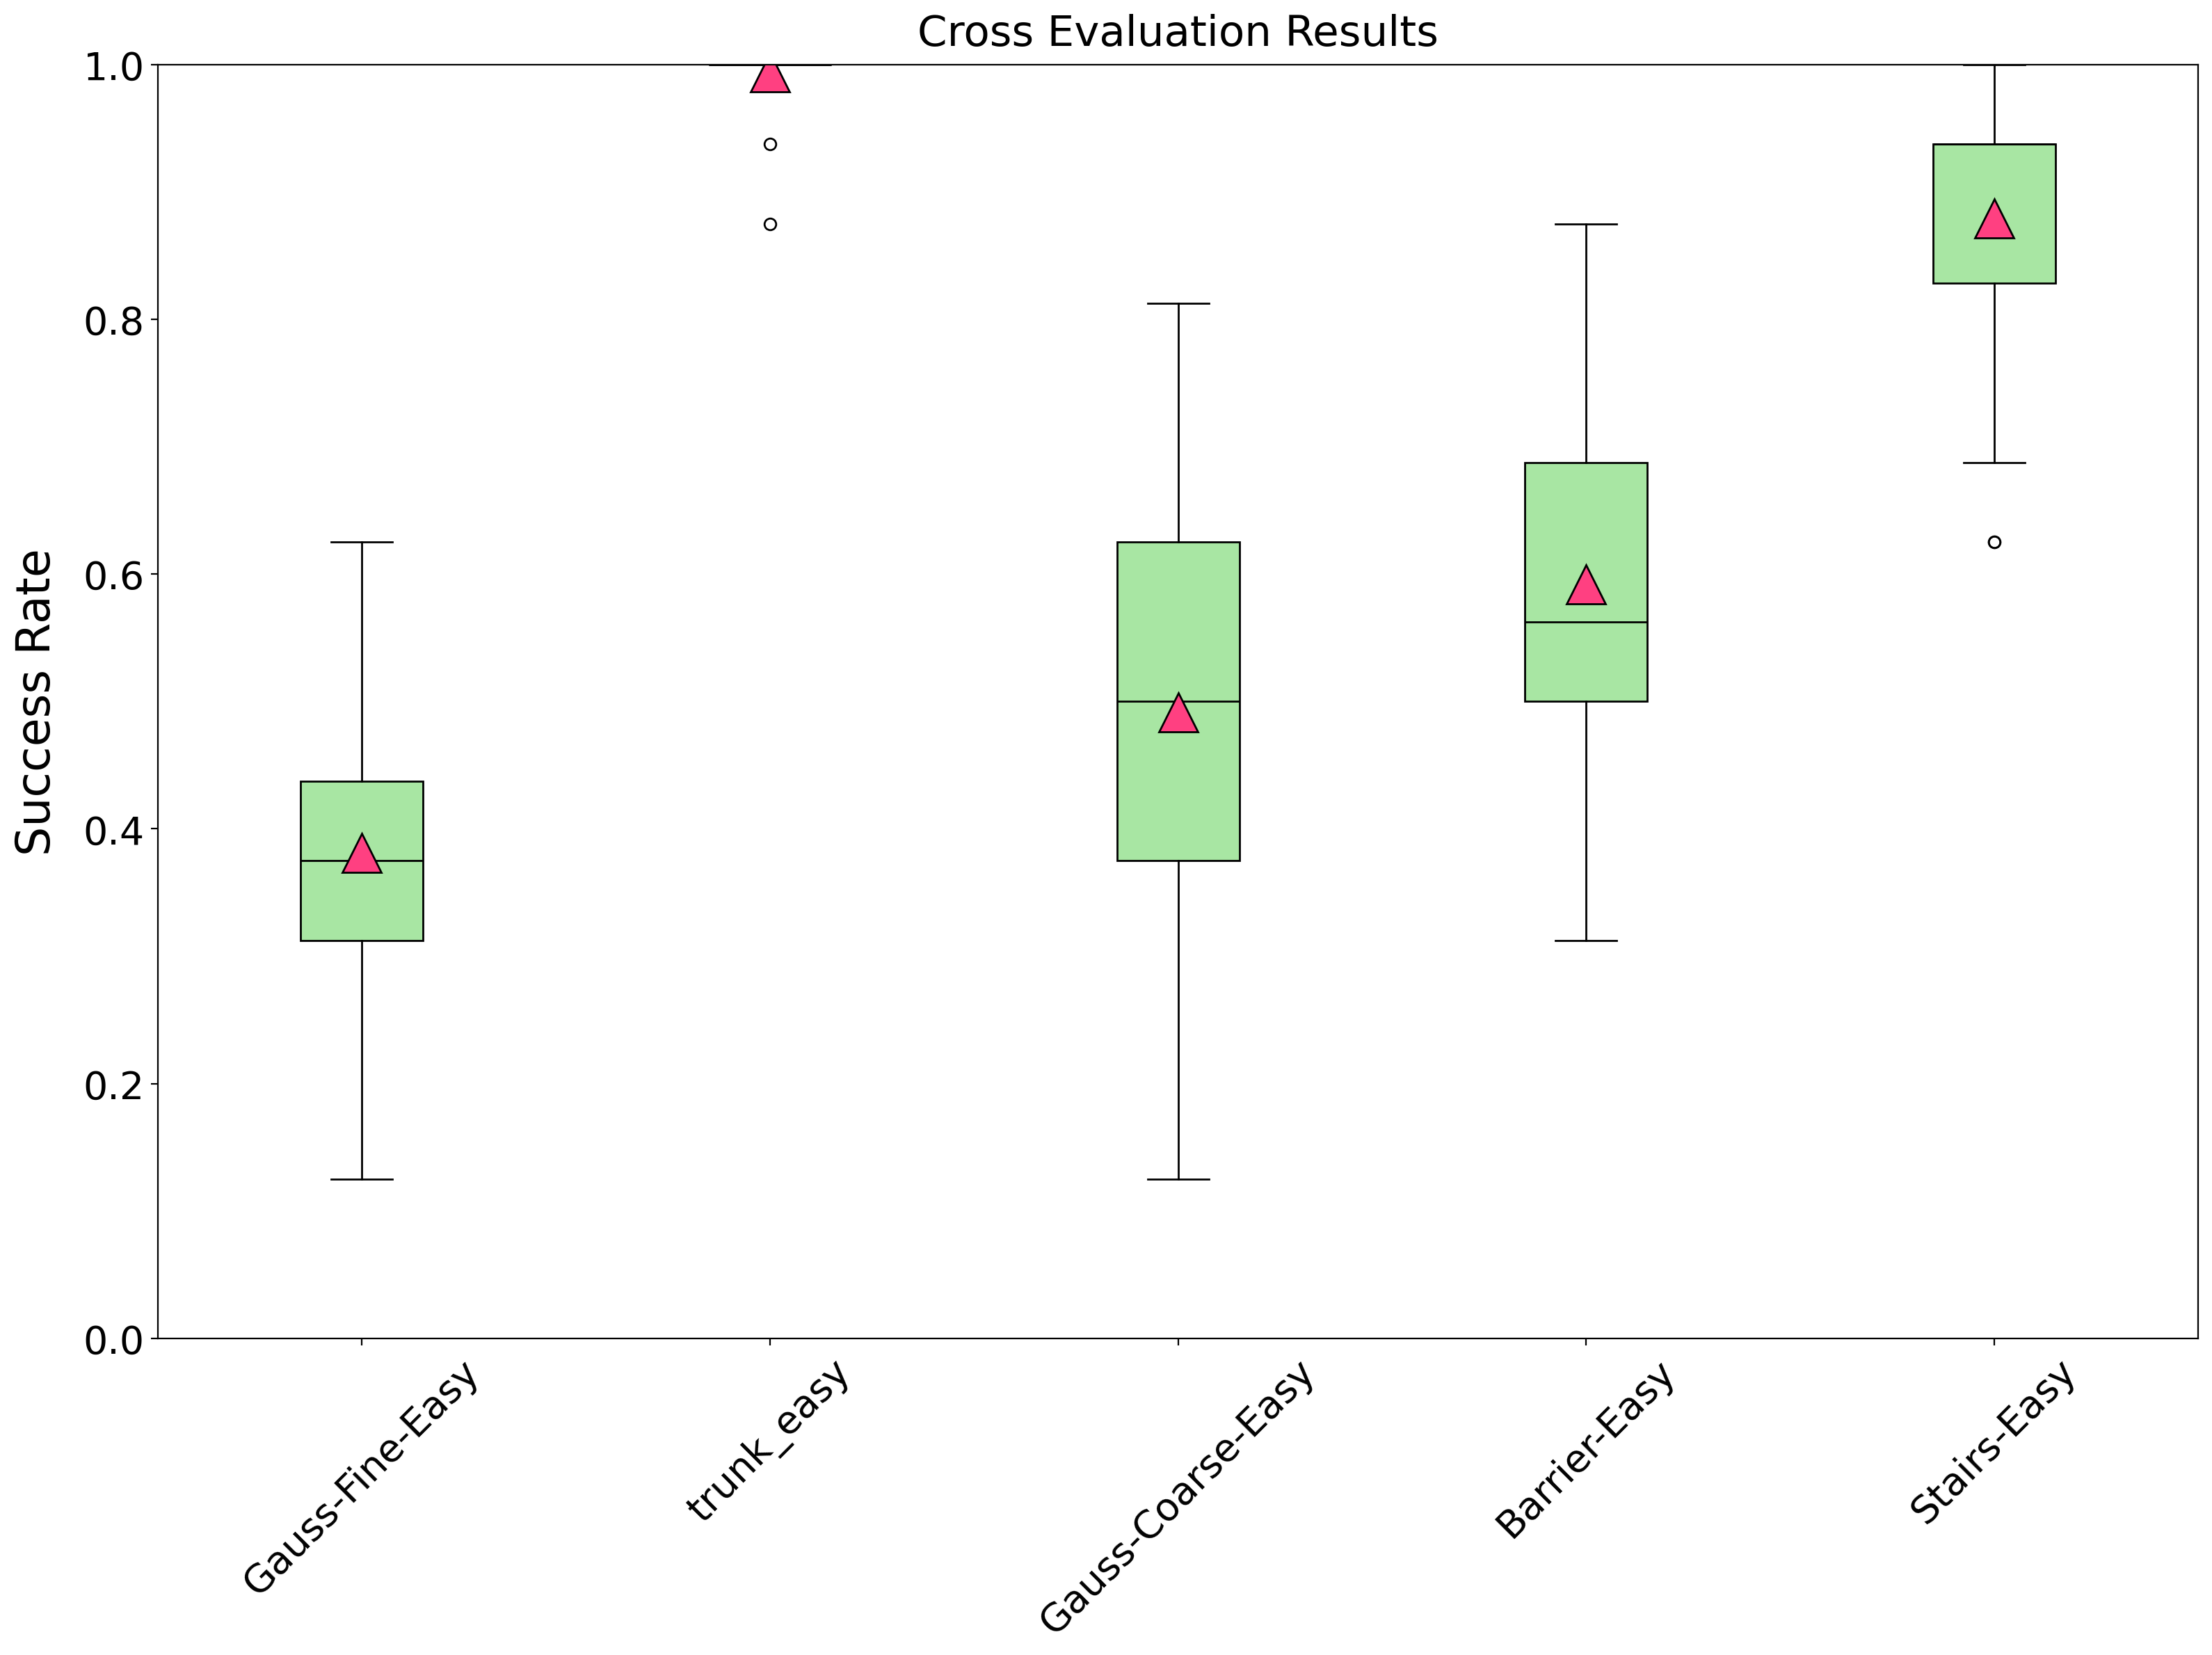

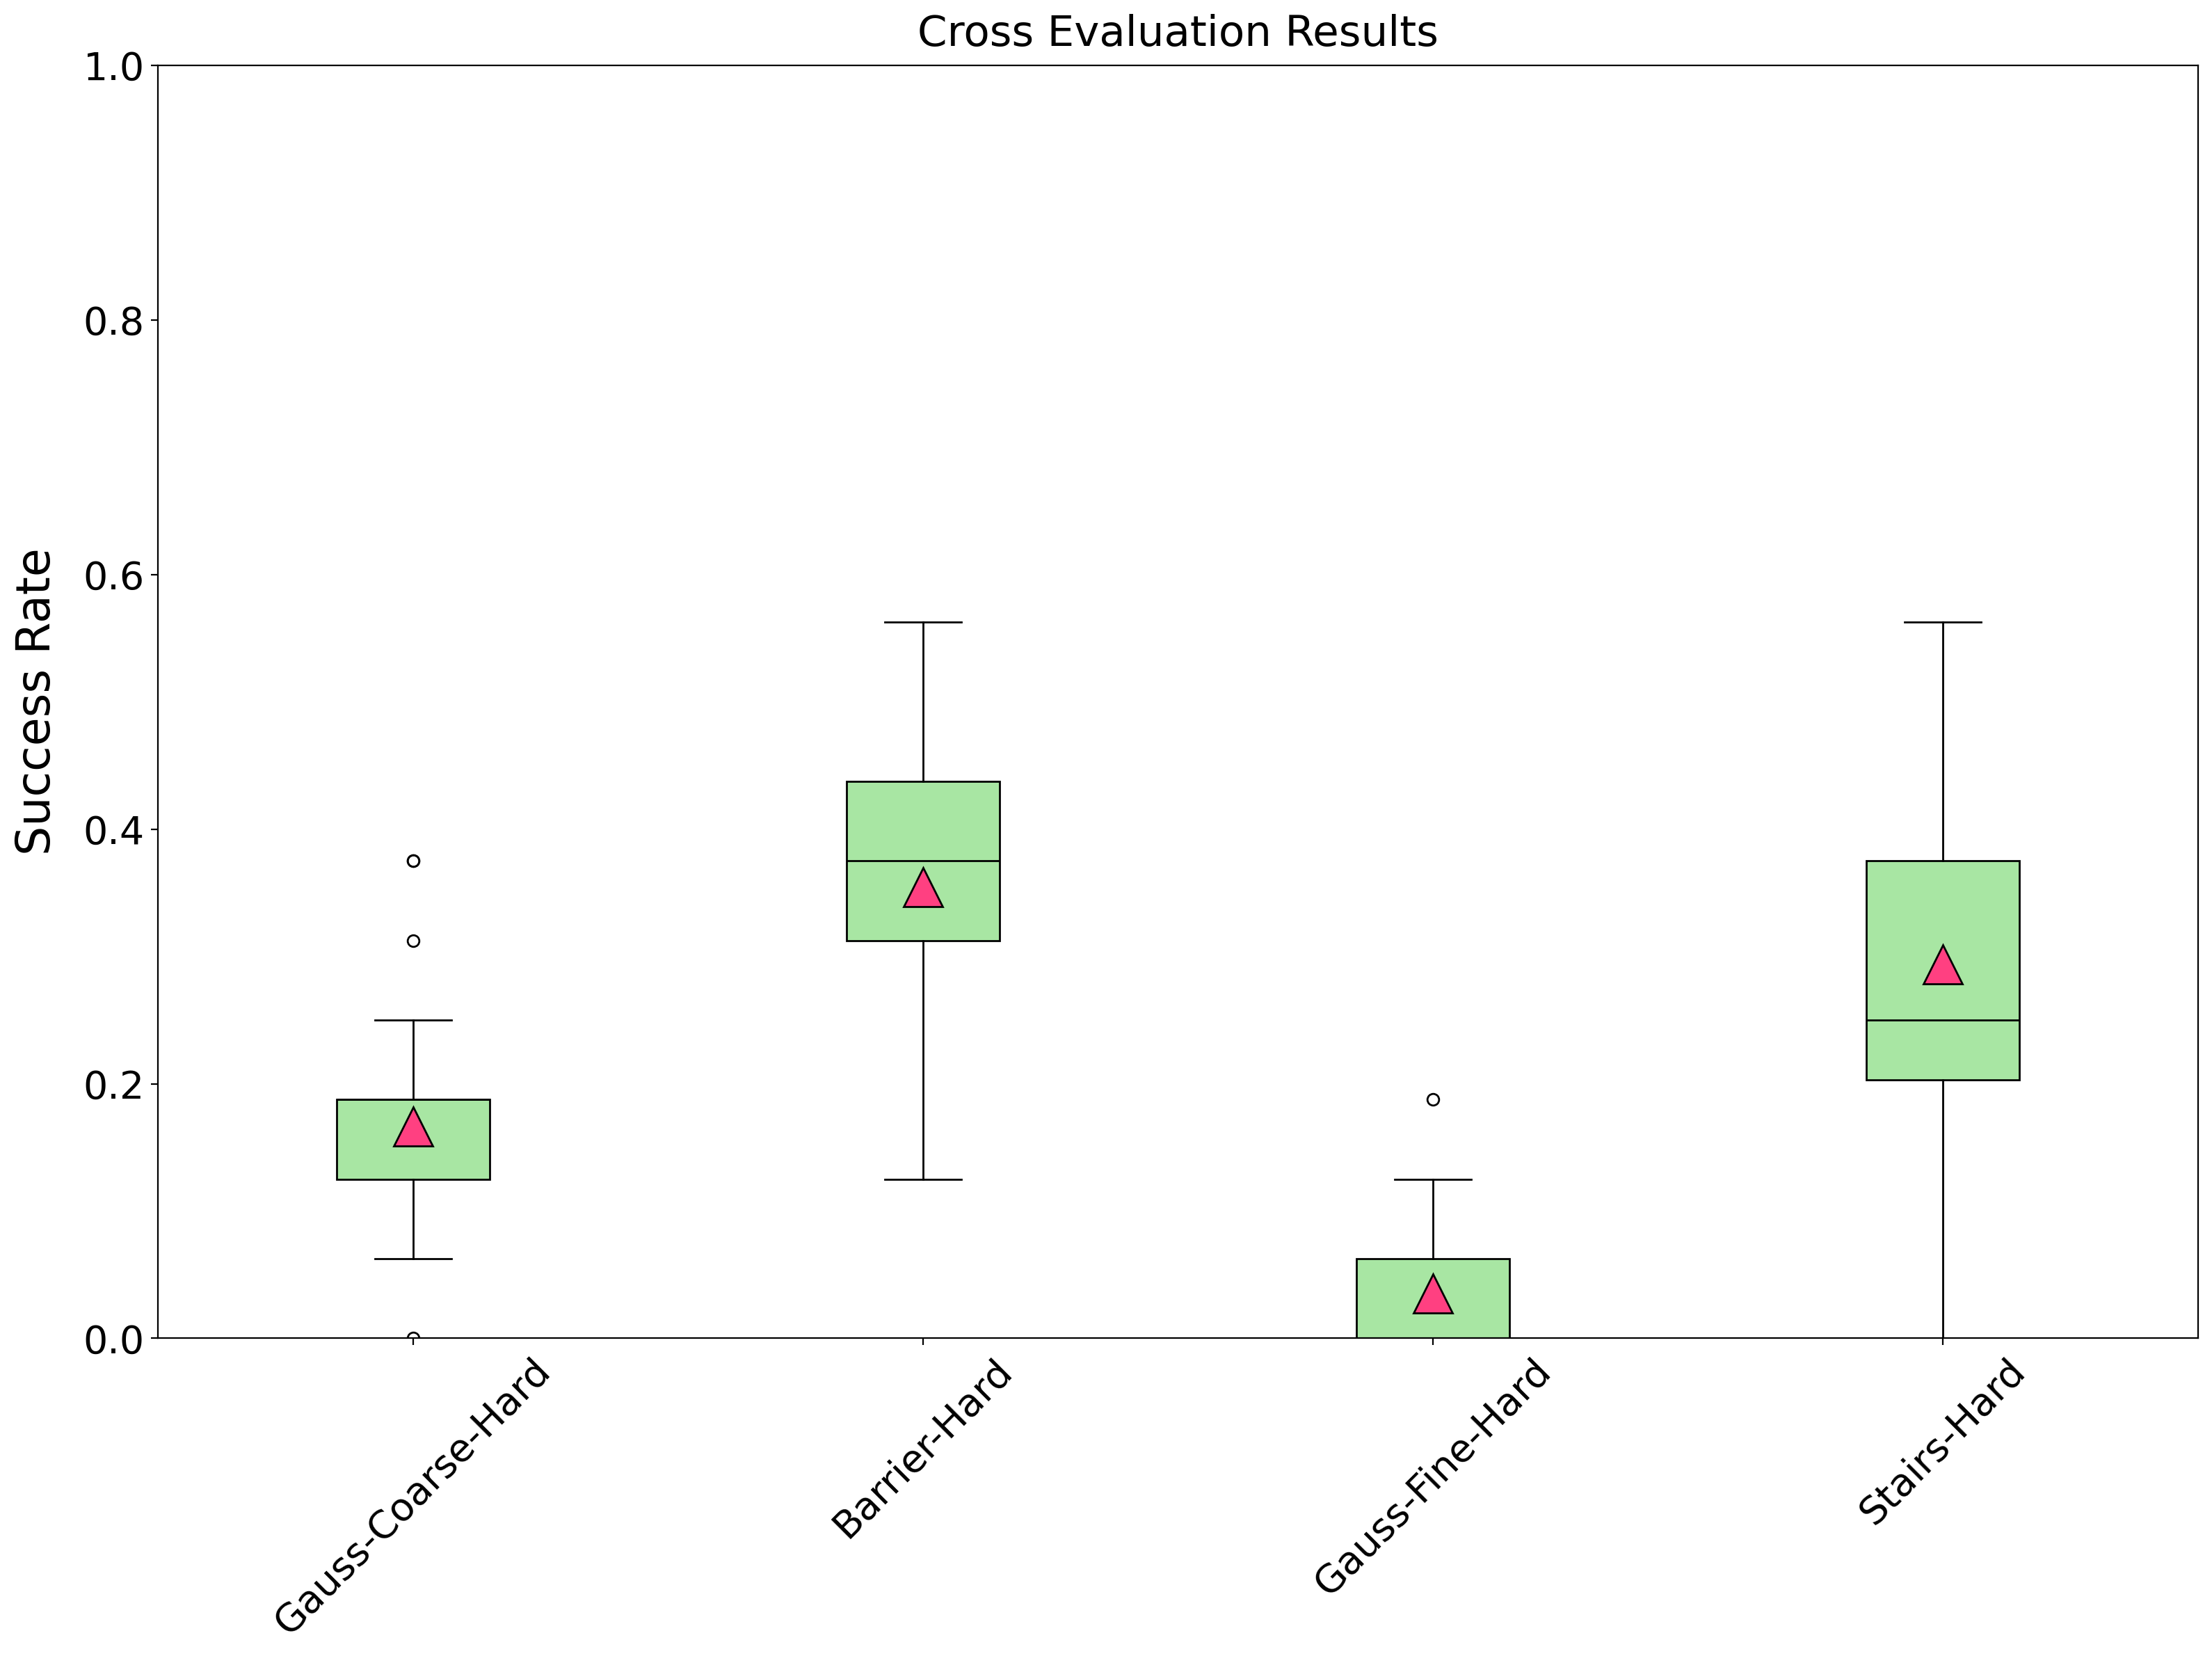

In [ ]:
import matplotlib

# matplotlib.rcParams["text.usetex"] = True

# Separate keys for easy/training and hard/training
easy_keys = [k for k in results_transposed if "easy" in k or "training" in k]
hard_keys = [k for k in results_transposed if "hard" in k or "training" in k]

# Plot for easy + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Success Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
green_color = "#a8e6a3"
line_color = "black"
for i, k in enumerate(easy_keys):
    v = results_transposed[k]
    pct_succeeded = v["eval/pct_succeeded"]
    ax.boxplot(
        pct_succeeded,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=green_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#ff4081", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(easy_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in easy_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

# Plot for hard + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Success Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
for i, k in enumerate(hard_keys):
    v = results_transposed[k]
    pct_succeeded = v["eval/pct_succeeded"]
    ax.boxplot(
        pct_succeeded,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=green_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#ff4081", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(hard_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in hard_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

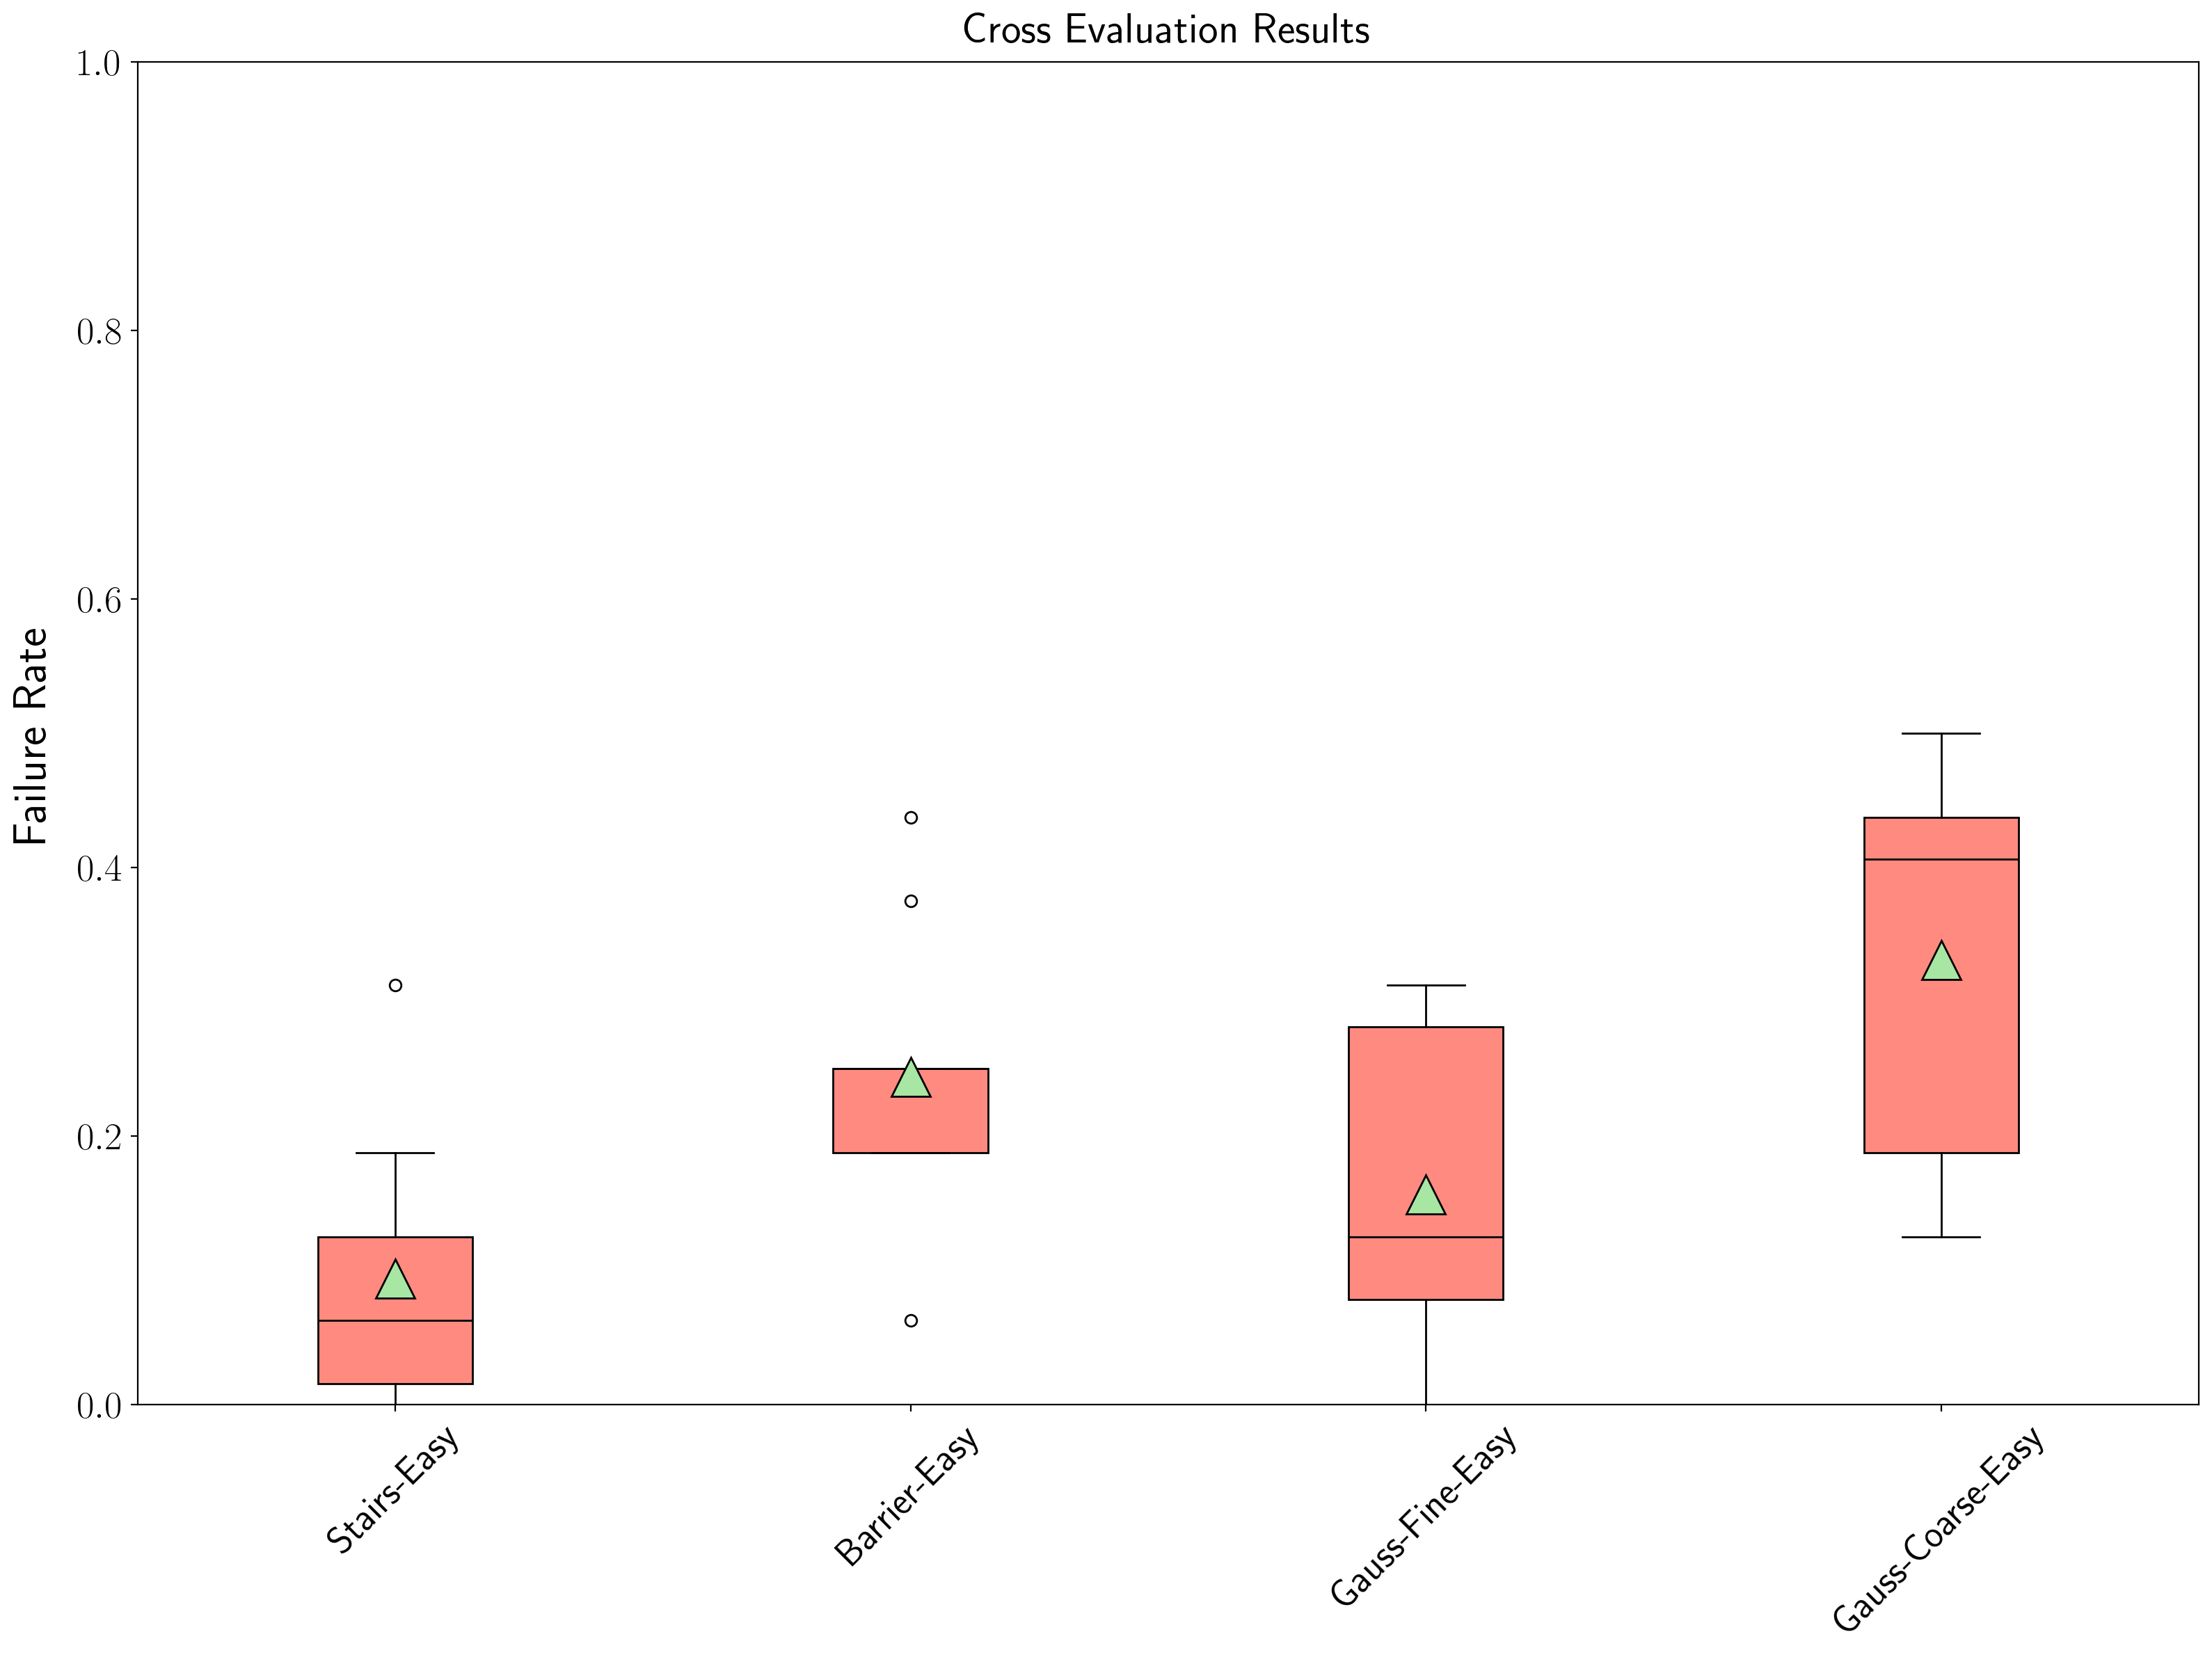

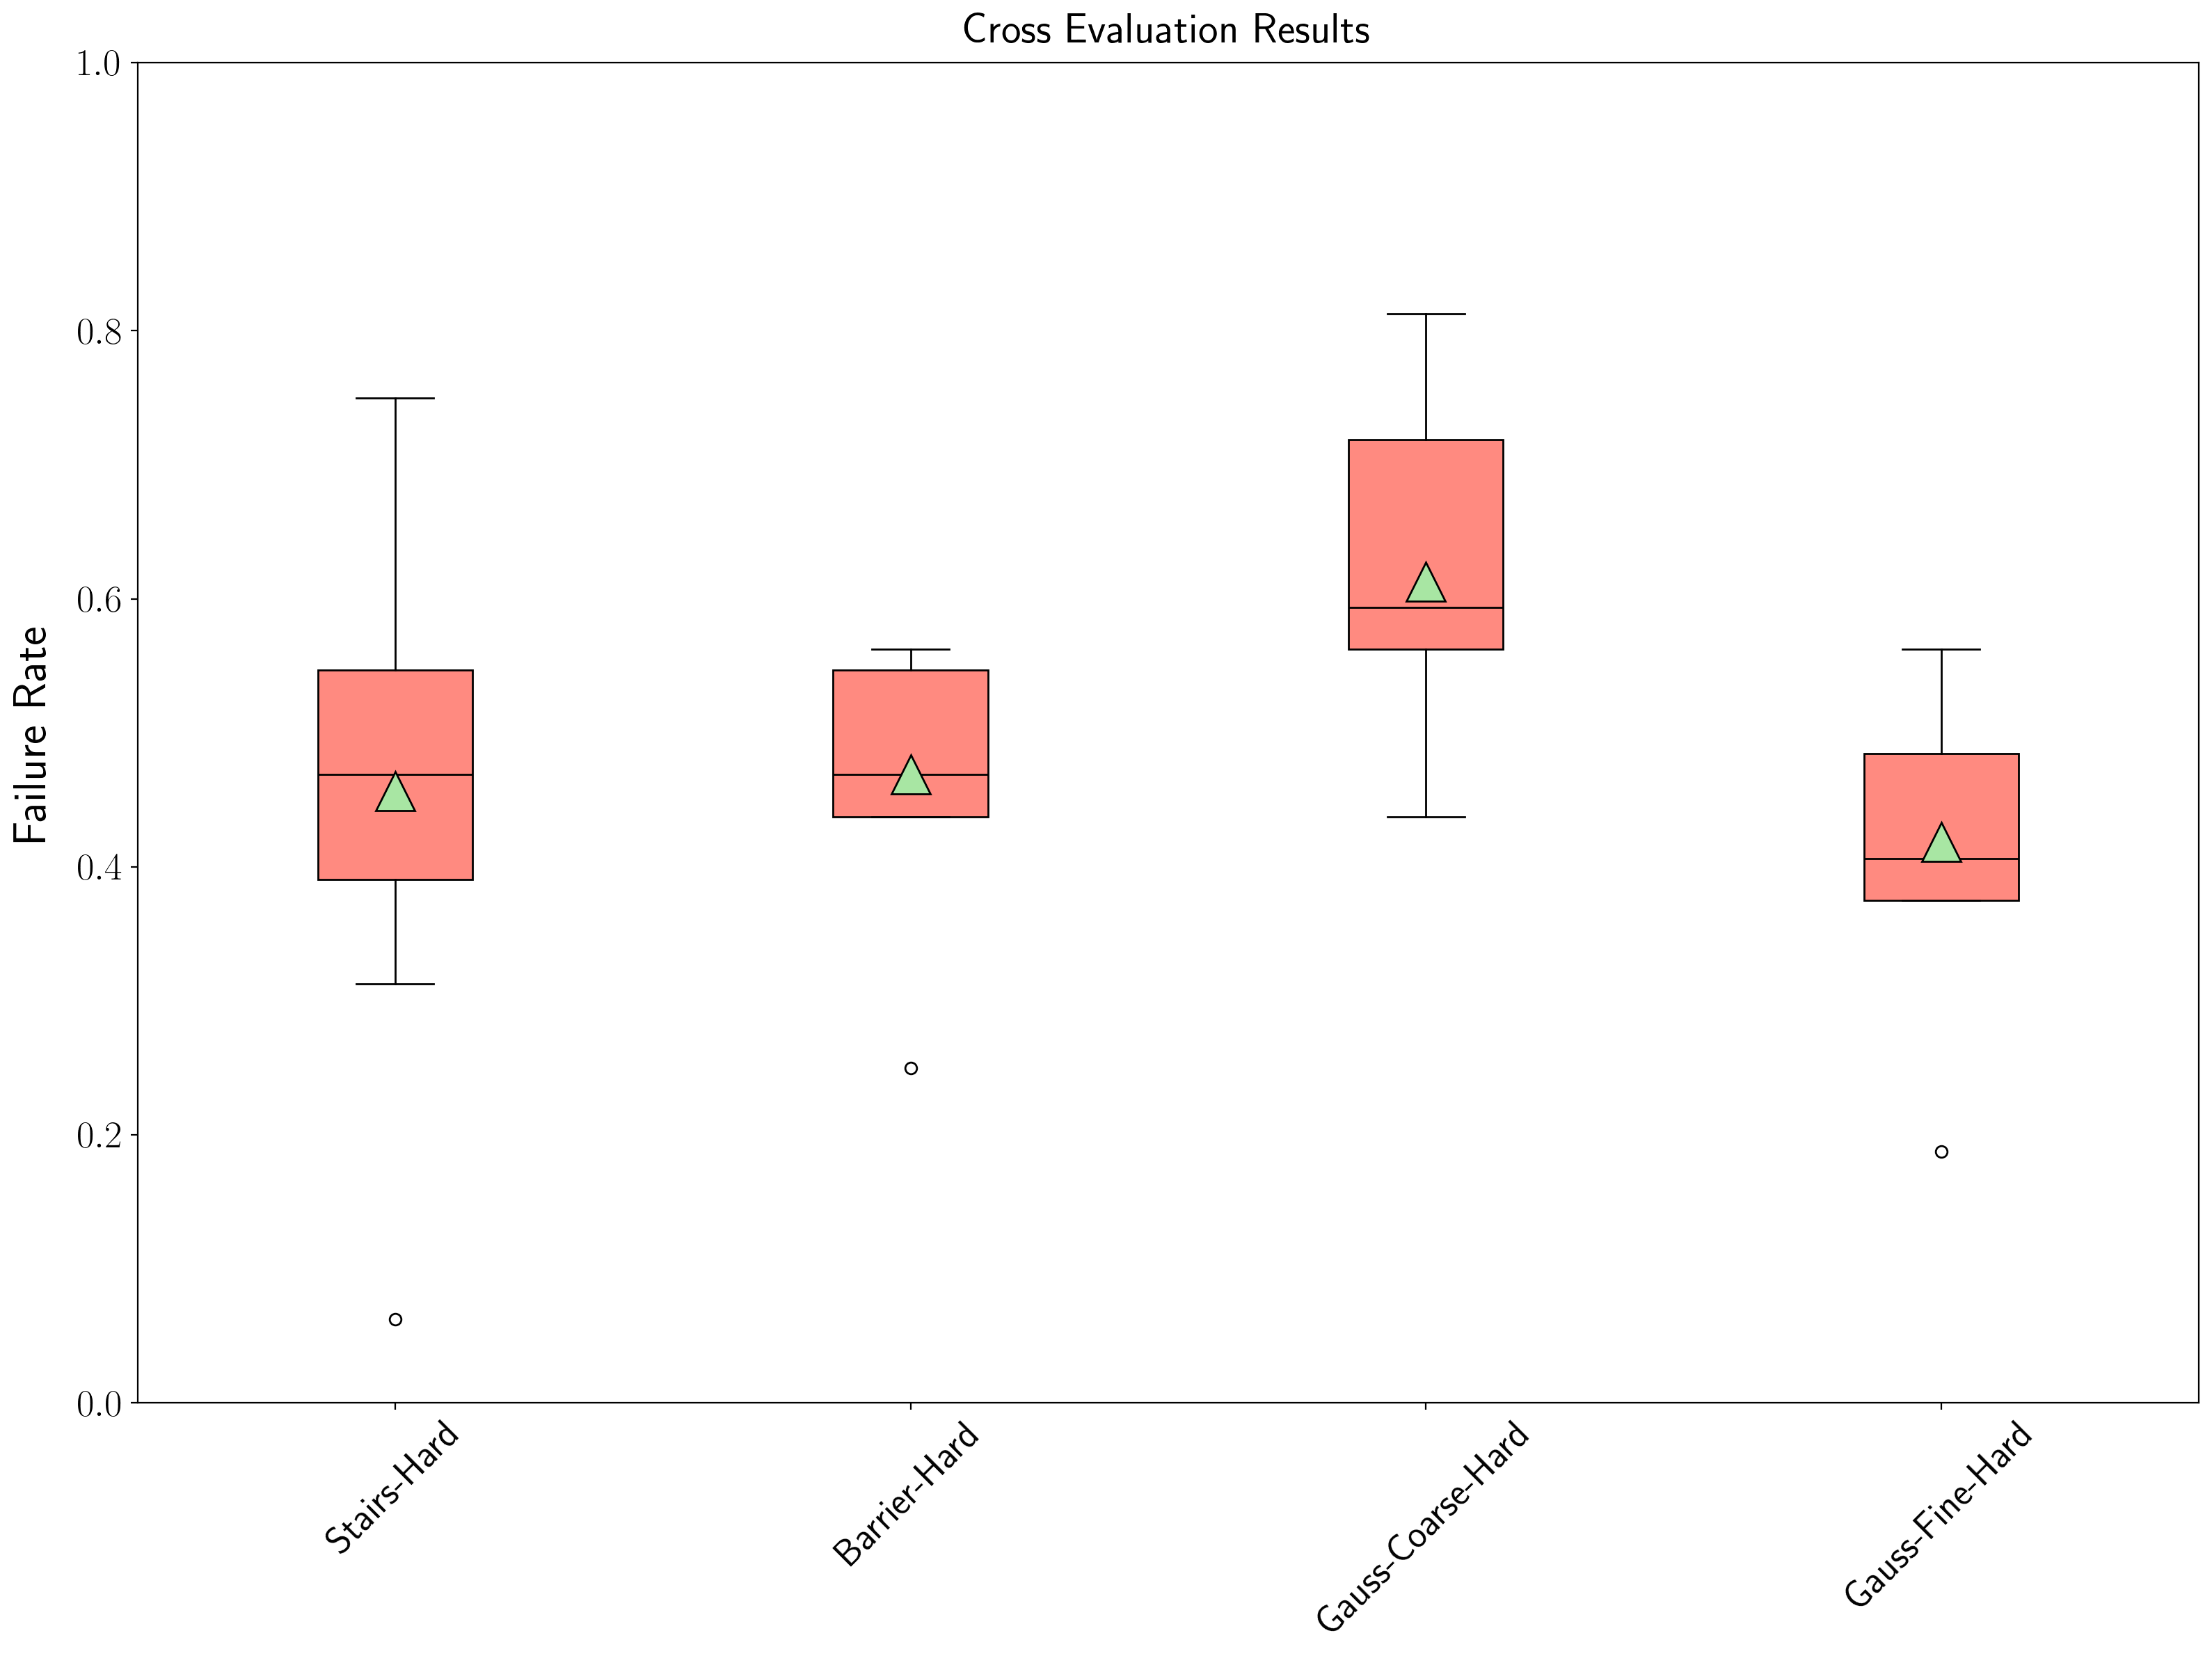

In [ ]:
import matplotlib

matplotlib.rcParams["text.usetex"] = True

# Separate keys for easy/training and hard/training
easy_keys = [k for k in results_transposed if "easy" in k or "training" in k]
hard_keys = [k for k in results_transposed if "hard" in k or "training" in k]

# Plot for easy + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Failure Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
red_color = "#ff8a80"
line_color = "black"
for i, k in enumerate(easy_keys):
    v = results_transposed[k]
    pct_failed = v["eval/pct_failed"]
    ax.boxplot(
        pct_failed,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=red_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#a8e6a3", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(easy_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in easy_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()

# Plot for hard + training
fig, ax = plt.subplots(1, 1, figsize=(16, 12), dpi=200)
ax.set_ylabel("Failure Rate", fontsize=24, labelpad=12)
ax.set_ylim(0, 1)
for i, k in enumerate(hard_keys):
    v = results_transposed[k]
    pct_failed = v["eval/pct_failed"]
    ax.boxplot(
        pct_failed,
        positions=[i],
        widths=0.3,
        patch_artist=True,
        boxprops=dict(facecolor=red_color, color=line_color),
        medianprops=dict(color=line_color),
        meanprops=dict(markerfacecolor="#a8e6a3", markeredgecolor="black", markersize=20),
        capprops=dict(color=line_color),
        whiskerprops=dict(color=line_color),
        showmeans=True,
    )
ax.set_xticks(range(len(hard_keys)))
ax.set_xticklabels([key2name.get(k.split(".")[0], k.split(".")[0]) for k in hard_keys], rotation=45, fontsize=20)
ax.tick_params(axis="y", labelsize=20)
ax.set_title("Cross Evaluation Results", fontsize=22, pad=10)
plt.tight_layout()
plt.show()